<a href="https://colab.research.google.com/github/yfstafford/Thinkful/blob/master/Thinkful_6_8_4_Analyzing_and_predicting_sentiment_from_Amazon_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you've looked at an example of how we can use Spark in batch mode, it's time to try it out on your own.

In this challenge you'll revisit the sentiment analysis we did earlier in the course - specifically, the Amazon reviews dataset. You should choose one of the 5-core datasets. Keep in mind that if the data is g-zipped, you'll need to unpack the dataset before you use it.

You should complete this challenge in a Jupyter notebook, which will need to work on Colab.

Now, on to the task at hand!

It's always important to start with a clear goal in mind. In this case, we'd like to determine if we can predict whether a review is positive or negative based on the language in the review.

We're going to tackle this problem with Spark, so you'll need to apply the principles you've learned thus far in the context of Spark.

Some tips to help you get started:

- Pyspark always needs to point at a running Spark instance. You can do that using a SparkContext.
- We're still working in batch mode, so you'll need to load an entire file into memory in order to run any models you build.
- Spark likes to execute models in a pipeline, so remember that when the time comes to set up your model.
- Spark's machine learning algorithms expect numeric variables.

When you're done, save your notebook and push it up to GitHub. Submit a link to your notebook below.

After submitting your work, review the example solution provided in your big data student resources directory - examples/Amazon Reviews Exercise.ipynb.

## Spark and Colaboratory setup

First, there's some configration specific to running Spark on Colaboratory that we'll need to attend to. Run these cells to set everything up.

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz

In [0]:
# Install spark-related depdencies for Python
!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 215.7MB 176kB/s 
     |████████████████████████████████| 204kB 34.7MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130387 sha256=8915f5951516aa74dc81971d840c3c20c06cce570215554c159338650c413bfd
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


In [0]:
# Set up required environment variables

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
# Point Colaboratory to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


##  Import dependencies

Next, we need to import the tools we'll need from PySpark. The imports below allow us to connect to the Spark server, load our data, clean it, and prepare, execute, and evaluate a model.

In [0]:
from pyspark import SparkContext, SQLContext
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier, LinearSVC, LogisticRegression
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler, Tokenizer, HashingTF, IDF
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql.functions import isnan, when, count, col

from matplotlib import pyplot as plt
import numpy as np
import functools
%matplotlib inline

## Set our constants

Next, we create a set of constants that we can refer to throughout the notebook. These are values that the rest of our code needs to run, but that we might need to change at some point (for instance, if the location of our data changes).

In [0]:
DATA_PATH = "/content/gdrive/My Drive/Colab Datasets/Kindle_Store_5.json" 
APP_NAME = "Kindle Review Sentiment"
SPARK_URL = "local[*]"
RANDOM_SEED = 47
TRAINING_DATA_RATIO = 0.8

## Connect to the server and load data

Data are stored in a JSON format file.

In [0]:
spark = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()

In [0]:
df0 = spark.read.options(inferschema = "true").json(DATA_PATH)

In [0]:
df0.head(5)

[Row(asin='B000F83SZQ', helpful=[0, 0], overall=5.0, reviewText="I enjoy vintage books and movies so I enjoyed reading this book.  The plot was unusual.  Don't think killing someone in self-defense but leaving the scene and the body without notifying the police or hitting someone in the jaw to knock them out would wash today.Still it was a good read for me.", reviewTime='05 5, 2014', reviewerID='A1F6404F1VG29J', reviewerName='Avidreader', summary='Nice vintage story', unixReviewTime=1399248000),
 Row(asin='B000F83SZQ', helpful=[2, 2], overall=4.0, reviewText="This book is a reissue of an old one; the author was born in 1910. It's of the era of, say, Nero Wolfe. The introduction was quite interesting, explaining who the author was and why he's been forgotten; I'd never heard of him.The language is a little dated at times, like calling a gun a &#34;heater.&#34;  I also made good use of my Fire's dictionary to look up words like &#34;deshabille&#34; and &#34;Canarsie.&#34; Still, it was w

## Clean and preprocess the data

Due to the size of the data set and memory constraints, only a sample of the full data set will be analyzed.

In [0]:
print(f"Dataset shape is {df0.count():d} rows by {len(df0.columns):d} columns.")

Dataset shape is 982619 rows by 9 columns.


In [0]:
# Take subsample to reduce RAM load
(df0, df1) = df0.randomSplit([0.05, 0.95], seed=RANDOM_SEED)

In [0]:
print(f"Dataset shape is {df0.count():d} rows by {len(df0.columns):d} columns.")

Dataset shape is 49281 rows by 9 columns.


In [0]:
df0.dtypes

[('asin', 'string'),
 ('helpful', 'array<bigint>'),
 ('overall', 'double'),
 ('reviewText', 'string'),
 ('reviewTime', 'string'),
 ('reviewerID', 'string'),
 ('reviewerName', 'string'),
 ('summary', 'string'),
 ('unixReviewTime', 'bigint')]

Reviews will be designated as positive or negative with reviews > 3 as positive.

In [0]:
df0 = df0.withColumn('positive',(df0['overall'] > 3).cast('double'))

([<matplotlib.axis.XTick at 0x7fc94bf35e80>,
 <a list of 2 Text xticklabel objects>)

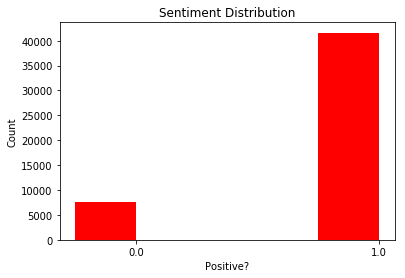

In [0]:
group_counts = df0.groupBy('positive').count().collect()

is_positive = [ c[0] for c in group_counts ]
counts = [ c[1] for c in group_counts ]
 
ax = np.array(range(len(is_positive)))
width = 0.25
plt.bar(ax, counts, width=width, color='r')

plt.xlabel('Positive?')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.xticks(ax + width/2., is_positive)

There is a group imbalance so measures such as accuracy may not be appropriate for this data set.

NLP processing will use tf-idf matrices.

In [0]:
# Tokenize
tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokenized").transform(df0)

In [0]:
#tf-idf processing
hashingTF = HashingTF(inputCol="tokenized", outputCol="rawFeatures", numFeatures=1000)
featurizedData = hashingTF.transform(tokenizer)
 
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
df = idfModel.transform(featurizedData)

In [0]:
df = df.select(['positive','features'])

Training indexers are needed for running models.

In [0]:
# Generate labelIndexer
labelIndexer = StringIndexer(inputCol="positive", outputCol="label").fit(df)
df = labelIndexer.transform(df)

df = df.select(['features','label'])

Data are split into training/test sets with 20% held out for testing.

In [0]:
(trainingData, testData) = df.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO], seed=RANDOM_SEED)

## Gradient Boosted Tree Model

By repeatedly passing residual data from a decision tree model to the next, gradient boosted tree models can generate good results, even if the relationship between variables is fairly weak.

In [0]:
# Train a Gradient Boosted model.
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=15)
model = gbt.fit(trainingData)

In [0]:
# Make predictions.
predictions = model.transform(testData)

The data set is imbalanced so rather than using accuracy, area under the ROC curve will be used to compare models.

In [0]:
# Calculate area under ROC curve
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.7965709478422993


In [0]:
predictions.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  120|
|  0.0|       1.0|   74|
|  1.0|       0.0| 1396|
|  0.0|       0.0| 8340|
+-----+----------+-----+



## LinearSVC Model

LinearSVC is relatively light in terms of resource requirements and so might be worth checking in a large data set such as this one.

In [0]:
# Train a LinearSVC model.
svc = LinearSVC(labelCol="label", featuresCol="features",maxIter=20)
model = svc.fit(trainingData)

In [0]:
# Make predictions.
predictions = model.transform(testData)

In [0]:
# Calculate area under ROC curve
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8568179808373149


In [0]:
predictions.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  233|
|  0.0|       1.0|   90|
|  1.0|       0.0| 1283|
|  0.0|       0.0| 8324|
+-----+----------+-----+



## Ridge Regression Model

Ridge regression allows for regularization and can be used to reduce the weight of less important features.

In [0]:
# Train a Ridge regression model.
lr = LogisticRegression(labelCol="label", featuresCol="features",maxIter=20,regParam=0.01)
model = lr.fit(trainingData)

In [0]:
# Make predictions.
predictions = model.transform(testData)

In [0]:
# Calculate area under ROC curve
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8606380213151472


In [0]:
predictions.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  461|
|  0.0|       1.0|  212|
|  1.0|       0.0| 1055|
|  0.0|       0.0| 8202|
+-----+----------+-----+



## Optimize Ridge Regression

In [0]:
(trainingData2, testData2) = df0.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO], seed=RANDOM_SEED)

In [0]:
# Configure an ML pipeline, which consists of five stages: tokenizer, hashingTF, IDF, li2, and lr.
tokenizer2 = Tokenizer(inputCol='reviewText', outputCol='tokenized')
hashingTF2 = HashingTF(inputCol='tokenized', outputCol='rawFeatures')
idf2 = IDF(inputCol="rawFeatures", outputCol="tfidf")

# Generate labelIndexer
li2 = StringIndexer(inputCol="positive", outputCol="label")

lr2 = LogisticRegression(labelCol="label", featuresCol="tfidf",maxIter=20)
pipeline2 = Pipeline(stages=[tokenizer2, hashingTF2, idf2, li2, lr2])

# Use a ParamGridBuilder in conjunction with a CrossValidator to perform a parameter grid search
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF2.numFeatures, [1000, 1500, 2000]) \
    .addGrid(lr2.regParam, [0.04, 0.02, 0]) \
    .build()

crossval = CrossValidator(estimator=pipeline2,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=4,            
                          collectSubModels=True)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(trainingData2)

In [0]:
# Find optimal parameters
cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ]

{Param(parent='HashingTF_47e2bf9c09fe', name='numFeatures', doc='number of features.'): 2000,
 Param(parent='LogisticRegression_3585af9ebc42', name='regParam', doc='regularization parameter (>= 0).'): 0.04}

In [0]:
# Make predictions
predictions = cvModel.transform(testData2)

In [0]:
# Calculate area under ROC curve
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8598129552311594


In [0]:
predictions.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  423|
|  0.0|       1.0|  141|
|  1.0|       0.0| 1147|
|  0.0|       0.0| 8219|
+-----+----------+-----+

